## Short-term volatility Prediction using Markov Model Classification & LSTM ML

### Import Packages

In [27]:
from yahoofinancials import YahooFinancials
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
from dateutil import parser

from matplotlib import pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

### Model Parameters & Document Settings

In [28]:
# timeframe
start_date="2001-02-01"
end_date="2022-04-14"
time_interval="daily"

# tickers
trade_ticker = "^GSPC"
vol_ticker = "^VIX"

# model parameters
nRegimes = 2
nIter = 1000

# style settings
style = "none"
color_scheme = "sunset"

### Download Data

In [29]:
gspc = YahooFinancials(trade_ticker)
gspc = gspc.get_historical_price_data(start_date=start_date, end_date=end_date, time_interval=time_interval)
gspc = pd.DataFrame(gspc[trade_ticker]['prices'])
gspc = gspc.drop('date', axis=1).set_index('formatted_date')

vix = YahooFinancials(vol_ticker)
vix = vix.get_historical_price_data(start_date=start_date, end_date=end_date, time_interval=time_interval)
vix = pd.DataFrame(vix[vol_ticker]['prices'])
vix = vix.drop('date', axis=1).set_index('formatted_date')

# calculate returns - assume close prices used
vix_pct = vix.pct_change()[1:]
gspc_pct = gspc.pct_change()[1:]

### Charts

In [30]:
fig = make_subplots(rows=2, cols=1)
fig.update_layout(title = "GSPC and VIX Daily Returns from "+start_date+" to "+end_date, template = style)
fig.add_trace(go.Scatter(
    x = gspc_pct.index,
    y = gspc_pct["close"], 
    name = "GSPC Returns"
), row = 1, col = 1)
fig.add_trace(go.Scatter(
    x = vix_pct.index,
    y = vix_pct["close"],
    name = "VIX Returns"
), row = 2, col = 1)

fig.show()

### Machine Learning Approach to Regime Classification
From previous notebook, Markov Switching & HMM, we found that Hidden Markov Model applied to GSPC returns & Markov Switching Dynamic Regression model applied to GSPC returns w/exog=VIX rets provide the best classifications for our purposes.

In [31]:
# plotting function for hidden states overlayed on chart
def plotHMM(data, hidden_states, ylabel= "y", title = "Chart"):
    sns.set()
    fig = plt.figure()
    subplt = fig.add_subplot(1,1,1)
    x = np.arange(len(data))
    
    unique_states = np.unique(hidden_states)
    for i in range(len(unique_states)):
        masks = hidden_states == unique_states[i]
        subplt.scatter(x[masks], data[masks], label= " ".join(["State", str(i+1)]))

    subplt.plot(x, data, c="k")
     
    subplt.set_xlabel('Days')
    subplt.set_ylabel(ylabel)
    subplt.set_title(title, loc="left")
    fig.subplots_adjust(bottom=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    # fig.legend(handles, labels, ncol=2, frameon=True)
    plt.show() 
    return None

##### Get Hidden Markov Model Classifications

In [32]:
# hidden gaussian markov model for gspc returns
reshaped_data_gspc = np.reshape(gspc_pct[["close"]], [len(gspc_pct[["close"]]), 1])
hgmm_model_gspc = GaussianHMM(n_components=nRegimes, n_iter=nIter).fit(reshaped_data_gspc)

hidden_states = hgmm_model_gspc.predict(reshaped_data_gspc)
mu = np.array(hgmm_model_gspc.means_)
sigma = np.array(np.sqrt(np.array([np.diag(hgmm_model_gspc.covars_[i]) for i in range(len(hgmm_model_gspc.covars_))])))
T = np.array(hgmm_model_gspc.transmat_)
# find log-likelihood of HMM
prob = hgmm_model_gspc.score(reshaped_data_gspc)

# results tuple for gspc markov
gspc_markov_results = (hidden_states, mu, sigma, T, prob)

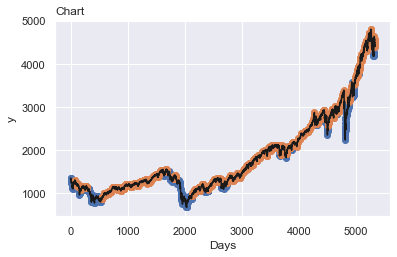

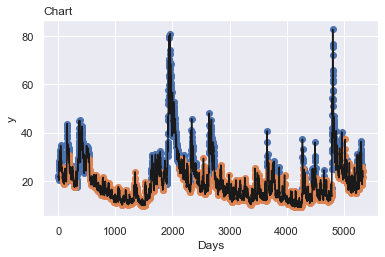

In [33]:
plotHMM(gspc[1:][["close"]], gspc_markov_results[0])
plotHMM(vix[1:][["close"]], gspc_markov_results[0])

##### Get MSDR - GSPC Classifications

In [43]:
msdr_model = sm.tsa.MarkovRegression(endog=gspc_pct['close'], k_regimes=nRegimes,
    trend='c', exog=vix_pct["close"], switching_variance=True)

msdr_model_results = msdr_model.fit(iter=nIter)

# print model training summary
# print(msdr_model_results.summary())

marg_probs_msdr = [msdr_model_results.smoothed_marginal_probabilities[i] for i in range(nRegimes)]

fig = make_subplots(rows=nRegimes+1, cols = 1)
fig.update_layout(template = style)
fig.add_trace(
        go.Scatter(y = gspc_pct["close"], x = gspc_pct.index, name = "GSPC % Change"),
        row = 1, col = 1
    )

for i in range(nRegimes):
    fig.add_trace(
        go.Scatter(y = marg_probs_msdr[i], x = gspc_pct.index, name = "GSPC+VIX Regime "+str(i)), 
        row=i+2, col=1,
    )

fig.show()
hidden_states_msdr_both = (marg_probs_msdr[0] > .5)*1

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: iter. After release 0.14, this will raise.


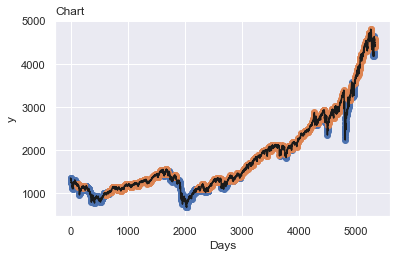

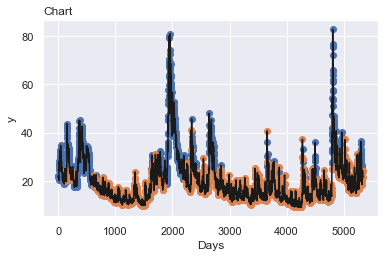

In [35]:
plotHMM(gspc[1:][["close"]], hidden_states_msdr_both)
plotHMM(vix[1:][["close"]], hidden_states_msdr_both)

In [36]:
msdr_model = sm.tsa.MarkovRegression(endog=vix_pct['close'], k_regimes=nRegimes,
    trend='c', switching_variance=True)

msdr_model_results = msdr_model.fit(iter=nIter)

marg_probs_msdr = [msdr_model_results.smoothed_marginal_probabilities[i] for i in range(nRegimes)]

# Plot
fig = make_subplots(rows=nRegimes+1, cols = 1)
fig.update_layout(template = style)
fig.add_trace(
        go.Scatter(y = gspc_pct["close"], x = gspc_pct.index, name = "GSPC % Change"),
        row = 1, col = 1
    )

for i in range(nRegimes):
    fig.add_trace(
        go.Scatter(y = marg_probs_msdr[i], x = gspc_pct.index, name = "VIX Regime "+str(i)), 
        row=i+2, col=1,
    )

fig.show()
hidden_states_msdr_vix = (marg_probs_msdr[0] > .5)*1

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: iter. After release 0.14, this will raise.


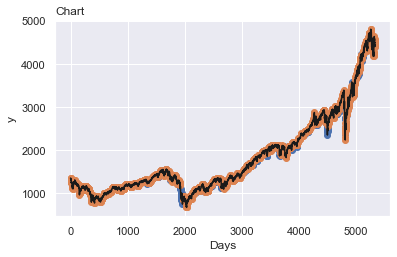

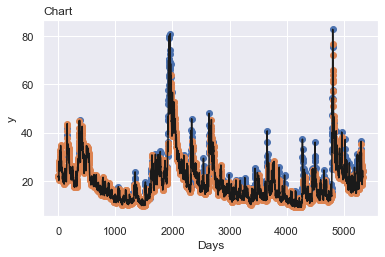

In [37]:
plotHMM(gspc[1:][["close"]], hidden_states_msdr_vix)
plotHMM(vix[1:][["close"]], hidden_states_msdr_vix)

### Marc's Macroindicators file

Imports

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle

import shap
from sklearn.model_selection import cross_val_score

Matching Dates & Making X, y

In [45]:
df = pd.read_csv("Data\MacroIndicators3.csv", index_col=0)
df = df.dropna()

hidden_states_msdr_data = hidden_states_msdr_both
msdr_dt = [parser.parse(hidden_states_msdr_both.index[i]).date() for i in range(len(hidden_states_msdr_both))]
hidden_states_msdr_data.index = msdr_dt

df_dt = [parser.parse(df.index[i]).date() for i in range(len(df.index))]
df.index = df_dt

common_dt = list(np.intersect1d(msdr_dt, df_dt))

In [46]:
lag = 5

hidden_states_msdr_data = hidden_states_msdr_data[common_dt][lag:]
hidden_states_msdr_data = hidden_states_msdr_data.reset_index(drop=True)
df_data = df.loc[common_dt, :][:-lag]
df_data = df_data.reset_index(drop=True)

Training

In [50]:
# 5 day lag 
X_train, X_test, y_train, y_test = train_test_split(df_data[0:1200], hidden_states_msdr_data[0:1200], test_size=.10)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

Training

In [51]:
# SVM
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

# Random Forest
clf_1 = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=10))
clf_1.fit(X_train, y_train)

cross_val_score(clf, X_train, y_train, cv=6)

array([0.96666667, 0.98333333, 0.98888889, 0.98333333, 0.97222222,
       0.98333333])

In [54]:
y_prime = clf.predict(df_data[1200:])
print("SVM: ", sum((y_prime == hidden_states_msdr_data[1200:])*1)/len(y_prime))

y_prime = clf_1.predict(df_data[1200:])
print("RF: ", sum((y_prime == hidden_states_msdr_data[1200:])*1)/len(y_prime))

SVM:  0.7574468085106383
RF:  0.7563829787234042


Error Matrix

In [57]:
y_test = hidden_states_msdr_data[1200:]

true1 = 0
true0 = 0
false1 = 0
false0 = 0
for i in range(len(y_prime)):
    if y_prime[i] == 1 and y_test[i] == 1:
        true1+=1
    if y_prime[i] == 1 and y_prime[i] != y_test[i]:
        false1+=1
    if y_prime[i] == 0 and y_prime[i] == y_test[i]:
        true0+=1
    if y_prime[i] == 0 and y_prime[i] != y_test[i]:
        false0+=1

TypeError: Cannot reset_index inplace on a Series to create a DataFrame

In [114]:
err = pd.DataFrame([[true0, false0], [false1, true1]])
err.columns = ["Actual 0", "Actual 1"]
err.index = ["Pred 0", "Pred 1"]
err

,Actual 0,Actual 1
Pred 0,71,9
Pred 1,6,278


Backtest but it's on the same data so...

In [115]:
# sum((clf.predict(df_data) == hidden_states_msdr_data)*1)/len(df_data)
backtest_weights = clf.predict(df_data)
i = 0
# while i < len(backtest_weights):
backtest_weights

array([1, 1, 1, ..., 0, 0, 0])